# EPL Winning Team Prediction

Author: [@Lakhder Amine](https://github.com/LakhderAmine99)

### General Description Of The Project

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc,roc_auc_score,precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import plotly.express as px

## Loading The Data

In [74]:
data = pd.read_csv("./data/EPL_Final_Dataset_Version_3.csv")
test_data = pd.read_csv("./data/EPL_Final_TestDataset_Version_3.csv")

data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,12/9/2020,Fulham,Arsenal,0,3,A,0,1,A,...,2,6,12,12,2,3,2,2,0,0
1,E0,12/9/2020,Crystal Palace,Southampton,1,0,H,1,0,H,...,3,5,14,11,7,3,2,1,0,0
2,E0,12/9/2020,Liverpool,Leeds,4,3,H,3,2,H,...,6,3,9,6,9,0,1,0,0,0
3,E0,12/9/2020,West Ham,Newcastle,0,2,A,0,0,D,...,3,2,13,7,8,7,2,2,0,0
4,E0,13/09/2020,West Brom,Leicester,0,3,A,0,0,D,...,1,7,12,9,2,5,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,E0,15/05/2016,Stoke,West Ham,2,1,H,0,1,A,...,4,7,8,12,4,10,3,1,0,0
2276,E0,15/05/2016,Swansea,Man City,1,1,D,1,1,D,...,1,5,4,19,4,4,1,3,0,0
2277,E0,15/05/2016,Watford,Sunderland,2,2,D,0,1,A,...,6,4,11,10,7,4,1,0,0,0
2278,E0,15/05/2016,West Brom,Liverpool,1,1,D,1,1,D,...,1,3,11,14,7,5,3,1,0,0


## Cleaning The Data

In [75]:
n_matches = data.shape[0]
n_features = data.shape[1] - 1

useful_data = data.copy()
useful_test_data = test_data.copy()

useful_data = useful_data.drop(["Div","Date"],axis=1)
useful_test_data = useful_test_data.drop(["Div","Date"],axis=1)

table_features = data.iloc[:,:7]
table_features = table_features.drop(["Div","Date","FTHG","FTAG"],axis=1)

print(table_features)

            HomeTeam     AwayTeam FTR
0             Fulham      Arsenal   A
1     Crystal Palace  Southampton   H
2          Liverpool        Leeds   H
3           West Ham    Newcastle   A
4          West Brom    Leicester   A
...              ...          ...  ..
2275           Stoke     West Ham   H
2276         Swansea     Man City   D
2277         Watford   Sunderland   D
2278       West Brom    Liverpool   D
2279      Man United  Bournemouth   H

[2280 rows x 3 columns]


## Constructing The Necessary Data Features

In [76]:
team_list = useful_data["HomeTeam"]

team_names = []

for team in team_list:
    if team not in team_names:
        team_names.append(team)
        
print("Teams From 2016 to 2021 :\n\n",team_names)

Teams From 2016 to 2021 :

 ['Fulham', 'Crystal Palace', 'Liverpool', 'West Ham', 'West Brom', 'Tottenham', 'Brighton', 'Sheffield United', 'Everton', 'Leeds', 'Man United', 'Arsenal', 'Southampton', 'Newcastle', 'Chelsea', 'Leicester', 'Aston Villa', 'Wolves', 'Burnley', 'Man City', 'Bournemouth', 'Watford', 'Norwich', 'Huddersfield', 'Cardiff', 'Stoke', 'Swansea', 'Hull', 'Middlesbrough', 'Sunderland']


## Useful Informations About The Data And Teams

In [77]:
n_homewins = len(useful_data[useful_data.FTR == "H"])
homewin_rate = float(n_homewins/n_matches)

print("Total Number Of Games :",n_matches)
print("Number Of Features :",n_features)
print("Number Of Home Wins :",n_homewins)
print("Home Win Rate :",homewin_rate,"%")

Total Number Of Games : 2280
Number Of Features : 22
Number Of Home Wins : 1014
Home Win Rate : 0.44473684210526315 %


## Getting The Team Data

In [78]:
def getTeamDataByName(teamName):
    print("========= Team Info",teamName,"=========\n")
    
    teamHomeData = useful_data[useful_data["HomeTeam"] == teamName]
    totalGoalsScored = teamHomeData["FTHG"].sum()
    
    teamAwayData = useful_data[useful_data["AwayTeam"] == teamName]
    totalGoalsScored += teamAwayData["FTAG"].sum()
    
    totalGames = pd.concat([teamHomeData,teamAwayData])
    numberOfGames = len(totalGames.index)
    
    totalGoalsAllowed = teamHomeData["FTHG"].sum()
    totalGoalsAllowed += teamAwayData["FTHG"].sum()
    
    totalYellowCards = teamHomeData['HY'].sum()
    totalYellowCards += teamAwayData['AY'].sum()
    
    totalRedCards = teamHomeData['HR'].sum()
    totalRedCards += teamAwayData['AR'].sum()
    
    totalFouls = teamHomeData['HF'].sum()
    totalFouls += teamAwayData['AF'].sum()
    
    totalCorners = teamHomeData['HC'].sum()
    totalCorners += teamAwayData['AC'].sum()
    
    totalShots = teamHomeData['HS'].sum()
    totalShots += teamAwayData['AS'].sum()
    
    totalShotsAgainst = teamHomeData['AS'].sum()
    totalShotsAgainst += teamAwayData['HS'].sum()
    
    if numberOfGames != 0:
        HSPG = totalShots/numberOfGames
        ASPG = totalShotsAgainst/numberOfGames
        
    gamesWon = totalGames[totalGames.FTR == "H"]
    gamesLost = totalGames[totalGames.FTR == "A"]
    gamesDraw = totalGames[totalGames.FTR == "D"]
    
    numberOfGamesWon = len(gamesWon.index)
    numberOfGamesLost = len(gamesLost.index)
    numberOfGamesDraw = len(gamesDraw.index)
    
    if numberOfGames != 0:
        GWP = float(numberOfGamesWon/numberOfGames)
        GLP = float(numberOfGamesLost/numberOfGames)
        GDP = float(numberOfGamesDraw/numberOfGames)
        
    totalShotsOnTarget = teamHomeData["HST"].sum()
    totalShotsOnTarget += teamAwayData["AST"].sum()
    
    goalSaves = totalShotsOnTarget - totalGoalsAllowed
    
    if totalShotsOnTarget != 0:
        goalSavesPercent = float(goalSaves/totalShotsOnTarget)
        
    if goalSaves != 0:
        saveRatio = float(totalShotsOnTarget/goalSaves)
    
    if totalShots != 0 :
        scoringPercent = float((totalShots - totalGoalsScored)/totalShots)
    
    if totalGoalsScored != 0:
        scoringRatio = float(totalShotsOnTarget / totalGoalsScored)
        
    print("Home Scoring Persentage :",HSPG,"%")
    print("Away Scoring Persentage :",ASPG,"%")
    print("Games Won Persentage :",GWP,"%")
    print("Games Lost Persentage :",GLP,"%")
    print("Games Draw Persentage :",GDP,"%")
        
    if numberOfGames == 0: 
        gamesWon = 0
        gamesLost = 0
        gamesDraw = 0 
        totalGoalsScored = 0 
        totalShotsOnTarget = 0 
        totalGoalsAllowed = 0 
        totalYellowCards = 0 
        totalRedCards = 0 
        totalFouls = 0 
        totalCorners = 0 
        totalShots = 0 
        totalShotsAgainst = 0 
        HSPG = 0
        ASPG = 0
        goalSaves = 0 
        goalSavesPercent = 0 
        scoringPercent = 0 
        saveRatio = 0 
        scoringRatio = 0
    
    return[
        teamName, 
        totalGoalsScored, 
        totalShotsOnTarget, 
        totalGoalsAllowed, 
        totalYellowCards, 
        totalRedCards,
        totalFouls, 
        totalCorners, 
        totalShots, 
        totalShotsAgainst, 
        HSPG, 
        ASPG, 
        goalSaves, 
        goalSavesPercent, 
        scoringPercent,
        saveRatio, 
        scoringRatio
    ]

In [79]:
print(getTeamDataByName("Man United"))

========= Team Info Man United =========

Home Scoring Persentage : 13.692982456140351 %
Away Scoring Persentage : 10.978070175438596 %
Games Won Persentage : 0.41228070175438597 %
Games Lost Persentage : 0.3157894736842105 %
Games Draw Persentage : 0.2719298245614035 %
['Man United', 375, 1187, 328, 414, 9, 2691, 1266, 3122, 2503, 13.692982456140351, 10.978070175438596, 859, 0.7236731255265375, 0.8798846893017297, 1.3818393480791618, 3.1653333333333333]


## Constructing The New Teams Vector Data

In [80]:
newTeamsStatsList = []
for team in team_names:
    team_vector = getTeamDataByName(team) 
    newTeamsStatsList.append(team_vector)
    
teamStats = pd.DataFrame(newTeamsStatsList, columns=['TeamName', 'totalGoalsScored', 'totalShotsOnTarget', 'totalGoalsAllowed', 
            'totalYellowCards', 'totalRedCards','totalFouls', 'totalCorners', 
            'totalShots', 'totalShotsAgainst', 'HSPG', 'ASPG', 'goalSaves', 'goalSavesPercent', 'scoringPercent',
            'saveRatio', 'scoringRatio'])

========= Team Info Fulham =========

Home Scoring Persentage : 11.776315789473685 %
Away Scoring Persentage : 13.31578947368421 %
Games Won Persentage : 0.40789473684210525 %
Games Lost Persentage : 0.35526315789473684 %
Games Draw Persentage : 0.23684210526315788 %
========= Team Info Crystal Palace =========

Home Scoring Persentage : 11.381578947368421 %
Away Scoring Persentage : 13.697368421052632 %
Games Won Persentage : 0.39473684210526316 %
Games Lost Persentage : 0.38596491228070173 %
Games Draw Persentage : 0.21929824561403508 %
========= Team Info Liverpool =========

Home Scoring Persentage : 16.135964912280702 %
Away Scoring Persentage : 8.635964912280702 %
Games Won Persentage : 0.43859649122807015 %
Games Lost Persentage : 0.32894736842105265 %
Games Draw Persentage : 0.2324561403508772 %
========= Team Info West Ham =========

Home Scoring Persentage : 12.06578947368421 %
Away Scoring Persentage : 13.50438596491228 %
Games Won Persentage : 0.4298245614035088 %
Games Los

In [81]:
teamStats

,TeamName,totalGoalsScored,totalShotsOnTarget,totalGoalsAllowed,totalYellowCards,totalRedCards,totalFouls,totalCorners,totalShots,totalShotsAgainst,HSPG,ASPG,goalSaves,goalSavesPercent,scoringPercent,saveRatio,scoringRatio
0,Fulham,61,285,101,134,5,907,325,895,1012,11.776316,13.315789,184,0.645614,0.931844,1.548913,4.672131
1,Crystal Palace,257,838,314,381,7,2579,1163,2595,3123,11.381579,13.697368,524,0.625298,0.900963,1.599237,3.260700
2,Liverpool,467,1343,390,274,7,2205,1511,3679,1969,16.135965,8.635965,953,0.709605,0.873063,1.409234,2.875803
3,West Ham,323,940,353,374,17,2260,1102,2751,3079,12.065789,13.504386,587,0.624468,0.882588,1.601363,2.910217
4,West Brom,143,455,198,266,8,1685,667,1499,2178,9.861842,14.328947,257,0.564835,0.904603,1.770428,3.181818
5,Tottenham,425,1249,362,374,10,2505,1335,3377,2611,14.811404,11.451754,887,0.710168,0.874149,1.408117,2.938824
6,Brighton,148,511,197,215,14,1688,716,1696,1993,11.157895,13.111842,314,0.614481,0.912736,1.627389,3.452703
7,Sheffield United,59,214,96,134,5,869,383,679,972,8.934211,12.789474,118,0.551402,0.913108,1.813559,3.627119
8,Everton,310,968,352,349,19,2523,1149,2715,2871,11.907895,12.592105,616,0.636364,0.885820,1.571429,3.122581
9,Leeds,62,199,61,61,1,427,231,522,558,13.736842,14.684211,138,0.693467,0.881226,1.442029,3.209677


## Ploting The Total Team Goals Scored

In [82]:
figure = px.bar(teamStats,x=teamStats.TeamName,y=teamStats.totalGoalsScored,color='TeamName')
figure.show()

## Ploting The Total Team SOT

In [83]:
figure = px.bar(teamStats,x=teamStats.TeamName,y=teamStats.totalShotsOnTarget,color='TeamName')
figure.show()

## Ploting The Total Team Home Shots Per Game

In [84]:
figure = px.bar(teamStats,x=teamStats.TeamName,y=teamStats.HSPG,color='TeamName')
figure.show()

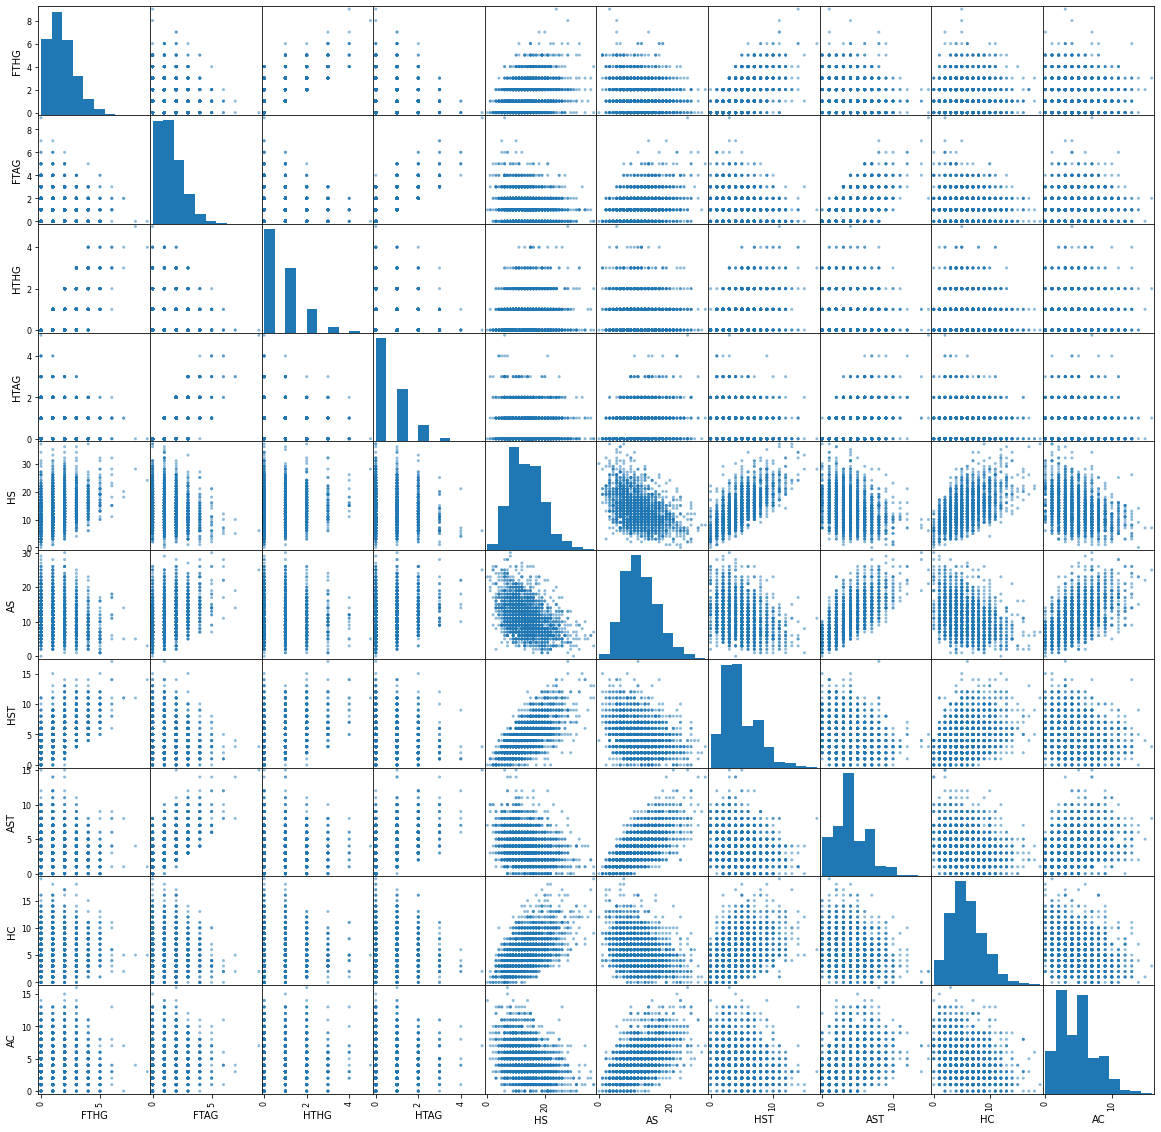

In [85]:
scatter_matrix(data[['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HC','AC']],figsize=(20,20));

In [86]:
filteredData = useful_data[(useful_data.HomeTeam.isin(team_names))]
useful_data = filteredData[(filteredData.AwayTeam.isin(team_names))]

useful_data

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,Fulham,Arsenal,0,3,A,0,1,A,C Kavanagh,5,...,2,6,12,12,2,3,2,2,0,0
1,Crystal Palace,Southampton,1,0,H,1,0,H,J Moss,5,...,3,5,14,11,7,3,2,1,0,0
2,Liverpool,Leeds,4,3,H,3,2,H,M Oliver,22,...,6,3,9,6,9,0,1,0,0,0
3,West Ham,Newcastle,0,2,A,0,0,D,S Attwell,15,...,3,2,13,7,8,7,2,2,0,0
4,West Brom,Leicester,0,3,A,0,0,D,A Taylor,7,...,1,7,12,9,2,5,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,Stoke,West Ham,2,1,H,0,1,A,M Jones,7,...,4,7,8,12,4,10,3,1,0,0
2276,Swansea,Man City,1,1,D,1,1,D,M Dean,4,...,1,5,4,19,4,4,1,3,0,0
2277,Watford,Sunderland,2,2,D,0,1,A,K Friend,21,...,6,4,11,10,7,4,1,0,0,0
2278,West Brom,Liverpool,1,1,D,1,1,D,R Madley,13,...,1,3,11,14,7,5,3,1,0,0


## Tronsform Data And Drop Unnecessary Columns

In [87]:
def transformResult(row):
    if(row.FTR == 'H'):
        return 1
    elif(row.FTR == 'A'):
        return -1
    else:
        return 0

In [88]:

useful_data = useful_data.drop(['HTR','Referee'],1)
useful_data["Result"] = useful_data.apply(lambda row: transformResult(row),axis=1)

useful_test_data = useful_test_data.drop(['HTR','Referee'],1)
useful_test_data["Result"] = useful_test_data.apply(lambda row: transformResult(row),axis=1)

C:\Users\amine\AppData\Local\Temp\ipykernel_17140\2993657005.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\amine\AppData\Local\Temp\ipykernel_17140\2993657005.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



## Preparing The Training And Testing Data

In [89]:
X_train = useful_data[['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','HF','AF','HY','AY','HR','AR','HC','AC','AST']]
y_train = useful_data['Result']

X_test = useful_test_data[['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','HF','AF','HY','AY','HR','AR','HC','AC','AST']]
y_test = useful_test_data['Result']

X_test

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,HF,AF,HY,AY,HR,AR,HC,AC,AST
0,2,0,1,0,8,22,3,12,8,0,0,0,0,2,5,4
1,5,1,1,0,16,10,8,11,9,1,2,0,0,5,4,3
2,1,2,1,0,14,14,3,10,7,2,1,0,0,7,6,8
3,3,0,2,0,13,4,6,15,11,0,0,0,0,5,2,1
4,3,1,0,1,14,6,6,13,15,2,0,0,0,6,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,0,1,0,6,10,3,12,22,2,4,0,0,3,6,4
376,4,1,0,0,12,7,6,10,5,0,1,0,0,3,3,2
377,3,1,1,1,29,7,8,6,3,1,0,0,0,5,3,5
378,3,2,0,1,24,4,5,5,11,0,1,0,0,13,1,2


In [90]:
clf_B = SVC(kernel='poly',probability=True)
clf_C = KNeighborsClassifier(n_neighbors = 10)
clf_D = DecisionTreeClassifier(max_depth=5)
clf_E = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)

y_pred = clf_B.fit(X_train,y_train).predict(X_test)
score = accuracy_score(y_pred,y_test)

print(score)

model = clf_E.fit(X_train,y_train)

0.9921052631578947


In [91]:
model.predict(X_test[:200])
pred_prob = model.predict_proba(X_test[:200])

In [92]:
data_still_need_testing = X_test[200:]
display(data_still_need_testing)

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,HF,AF,HY,AY,HR,AR,HC,AC,AST
200,2,3,1,2,15,18,5,6,9,3,2,0,0,4,3,5
201,1,1,0,1,10,15,2,8,5,1,2,0,0,5,7,3
202,2,3,1,1,14,27,4,6,12,1,2,0,0,3,8,10
203,1,3,0,0,18,13,8,7,9,0,0,0,0,6,9,5
204,0,3,0,0,15,7,4,16,11,0,1,1,0,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,0,1,0,6,10,3,12,22,2,4,0,0,3,6,4
376,4,1,0,0,12,7,6,10,5,0,1,0,0,3,3,2
377,3,1,1,1,29,7,8,6,3,1,0,0,0,5,3,5
378,3,2,0,1,24,4,5,5,11,0,1,0,0,13,1,2


In [93]:
x_pos_start = 357
x_pos_end = 358

print(test_data[x_pos_start:x_pos_end].FTR)
print(test_data[x_pos_start:x_pos_end].HomeTeam)
print(test_data[x_pos_start:x_pos_end].AwayTeam)

vector = X_test.iloc[x_pos_start:x_pos_end]
print(vector)

res_prob = model.predict_proba(vector)
res = model.predict(vector)
print(res_prob)
print(res)

357    H
Name: FTR, dtype: object
357    Tottenham
Name: HomeTeam, dtype: object
357    Arsenal
Name: AwayTeam, dtype: object
     FTHG  FTAG  HTHG  HTAG  HS  AS  HST  HF  AF  HY  AY  HR  AR  HC  AC  AST
357     3     0     2     0  16   8    6   8  15   1   3   0   1   2   2    4
[[0.00983349 0.01811052 0.97205598]]
[1]


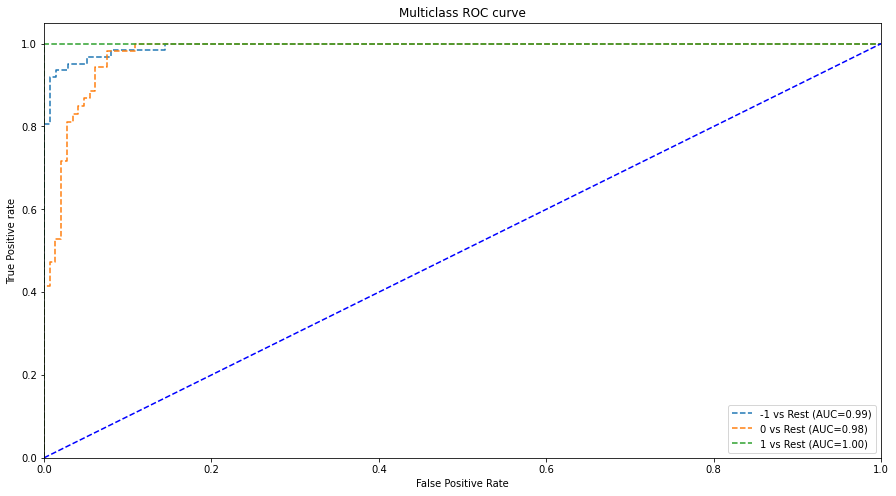

In [96]:
y_test_binarized=label_binarize(y_test[:200],classes=np.unique(y_test))

fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes=np.unique(y_test)

n_class = classes.shape[0]

plt.figure(figsize=(15,8))

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [95]:
fig = go.Figure()
fig.add_shape(
    type="line" , line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(pred_prob.shape[1]):
    y_true = y_test_binarized[:, i]
    y_score = pred_prob[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{y_test_binarized[i]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="y", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=650
)
fig.show()